In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import inspect
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score, roc_curve

warnings.filterwarnings('ignore')

## **1. Prepare data**

In [2]:
# data read
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv') # 건드리지 말것.
train_1 = train.astype('category').copy()
randomstate = 123

# ready for encoding
train_2 = train_1.iloc[:,1:].copy()
target_y = train_1.iloc[:,0].copy()

In [3]:
# LabelEncoding
def label_encoding(x, columns):
    x_dict={}
    encoding_X = x[columns]
    encoder = LabelEncoder()
    
    encoder.fit(encoding_X)
    
    x_list = encoder.transform(encoding_X)
    x_dict[columns] = x_list.tolist()

    return x_dict    

def label_encoding_concat(main):
    x_train_dict_1 = {}
    for i in main.columns:
        x_train_label = label_encoding(main, i)
        x_train_dict_1.update(x_train_label)
        
        x_train_df = pd.DataFrame(x_train_dict_1)
    
    return x_train_df

In [4]:
# OneHotEncoding
def make_dummy(dataframe_value):
    dummy_X = pd.get_dummies(dataframe_value)
    return dummy_X

In [5]:
# dummy encoding
X_train_dummies = make_dummy(train_2)

## **2. HyperParameter Tuning**

### 모델의 학습 과정
- get_dummies로 만든 원핫인코딩 데이터를 gridsearchcv를 통해 돌려본다.
- 파라미터를 조금씩 변경해봐서 돌린 후 값이 제일 잘 나온 파라미터를 최종 선택한다. 

In [6]:
# 랜덤포레스트 하이퍼 파라미터 튜닝하기
rf = RandomForestClassifier(random_state=123)

param_rf = {
            "n_estimators" : [10,50,100,200,300,500],
            "min_samples_leaf" : [1,3,5],
            "min_samples_split" : [1,3,5],
            "max_depth" : [10,50,100,200,300,500]
            }

# train & test 데이터 세팅
X_train, X_test, y_train, y_test = train_test_split(
    X_train_dummies, target_y, test_size=0.2, random_state=123)

gscv = GridSearchCV (estimator = rf,
                                param_grid = param_rf,
                                scoring ='roc_auc',
                                cv = 2,
                                n_jobs=-1,
                                verbose=0)

gscv.fit(X_train, y_train)
print(f'최적의 파라미터 :', gscv.best_params_)
print(f'최고 스코어 : {gscv.best_score_:.4f}')

## * 최종모델 : RandomForestClassifier

- 최적의 파라미터 : {'max_depth': 300, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500}

- 최고 스코어 : 0.8259

In [10]:
# 결과값 확인해보기!
gb = gscv.best_estimator_
pred = gb.predict(X_test)
roc_auc_score(y_test,pred)


0.6514739781014645

In [24]:
rf = RandomForestClassifier(
            random_state=123, 
            n_estimators =300,
            min_samples_leaf =1,
            min_samples_split =3,
            max_depth =500
            ).fit(X_train, y_train)

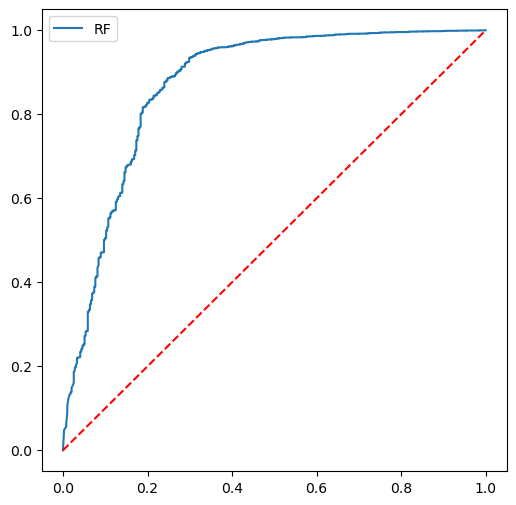

In [27]:
# roc 곡선 그려보기
score1 = rf.predict_proba(X_test)[:,1]
fpr, tpr, cut1 = roc_curve(y_test, score1)

fig = plt.figure(figsize=(6,6))
ax = fig.subplots()
ax.plot(fpr, tpr, label='RF')
ax.plot([0,1],[0,1], color='red', linestyle='--')
ax.legend()
plt.show()

---
### 향후계획
- 연산 속도가 너무 오래 걸려 쉽게 사용할 수 없었다. (최소 2시간)
- 최적합 점수가 82%이나 실제 테스트셋은 62%인점 -> 과적합 의심
  * 해결방안
  1. 원핫인코딩 -> 라벨인코딩
     - 원핫인코딩은 피처수가 너무 많아지므로 과적합이 우려되긴했었다.
     - 라벨인코딩으로 변경하여 적용해보는 게 좋을 것 같다.
  2. 오버샘플링 적용
     - 데이터 EDA 시 1값이 압도적으로 많은 것을 볼 수 있었다.
     - 라벨인코딩으로도 잘 안되면 오버샘플링을 적용해보자.